# <span style="font-family:cursive;text-align:center">⬇️ Import Libraries</span>

In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Resizing, Normalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import LSTM, Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
&nbsp;<b>The function create_spectrogram takes an input audio file path and generates a spectrogram image, saving it to the specified image file path. It utilizes the librosa library to load the audio, compute its mel spectrogram, and convert the power spectrogram to a decibel scale for better visualization.</b><br>
<br>
&nbsp;<b>The create_pngs_from_wavs function automates the process for multiple audio files within a given directory. It converts all .wav files in the specified input directory into spectrogram images, saving the resulting images to the designated output directory. This function makes use of the create_spectrogram function internally to generate the spectrogram images.

# <span style="font-family:cursive;text-align:center">📊 Data Processing and Training set generation</span>

In [2]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [3]:
create_pngs_from_wavs('/kaggle/input/aud-data/aug-dataset1/belly_pain', '/kaggle/working/belly_pain')
create_pngs_from_wavs('/kaggle/input/aud-data/aug-dataset1/burping', '/kaggle/working/burping')
create_pngs_from_wavs('/kaggle/input/aud-data/aug-dataset1/discomfort', '/kaggle/working/discomfort')
create_pngs_from_wavs('/kaggle/input/aud-data/aug-dataset1/hungry', '/kaggle/working/hungry')
create_pngs_from_wavs('/kaggle/input/aud-data/aug-dataset1/tired', '/kaggle/working/tired')

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>Loading the images from the path</b><br>
</div>

In [4]:
x = []
y = []

from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
     &nbsp;<b>The function takes in source patterns and their corresponding destination paths as input. If the destination directory doesn't exist, it creates the directory and proceeds with moving the files. It utilizes the glob module to identify the files based on the specified patterns and shutil for the file movement.
</b><br>
    <br>
    &nbsp;<b>With this we create the training dataset and leave a file for each type for testing</b><br>
</div>

In [5]:
import glob
import shutil

def move_files(source_pattern, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Directory '{destination_path}' created successfully.")
    else:
        print(f"Directory '{destination_path}' already exists.")

    files_to_move = glob.glob(source_pattern)
    for file_path in files_to_move[:-1]:
        shutil.move(file_path, destination_path)

# Define your directories and source patterns
directories = {
    '/kaggle/working/belly_pain_train/': '/kaggle/working/belly_pain/*.png',
    '/kaggle/working/burping_train/': '/kaggle/working/burping/*.png',
    '/kaggle/working/discomfort_train/': '/kaggle/working/discomfort/*.png',
    '/kaggle/working/hungry_train/': '/kaggle/working/hungry/*.png',
    '/kaggle/working/tired_train/': '/kaggle/working/tired/*.png'
}

# Loop through the directories and move the files
for directory, source_pattern in directories.items():
    move_files(source_pattern, directory)

Directory '/kaggle/working/belly_pain_train/' created successfully.
Directory '/kaggle/working/burping_train/' created successfully.
Directory '/kaggle/working/discomfort_train/' created successfully.
Directory '/kaggle/working/hungry_train/' created successfully.
Directory '/kaggle/working/tired_train/' created successfully.


In [6]:
images, labels = load_images_from_path('/kaggle/working/belly_pain_train', 0)

x += images
y += labels

images, labels = load_images_from_path('/kaggle/working/burping_train', 1)

x += images
y += labels

images, labels = load_images_from_path('/kaggle/working/discomfort_train', 2)

x += images
y += labels

images, labels = load_images_from_path('/kaggle/working/hungry_train', 3)

x += images
y += labels

images, labels = load_images_from_path('/kaggle/working/tired_train', 4)

x += images
y += labels

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255
x_val_norm = np.array(x_val) / 255
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_val_encoded = to_categorical(y_val, num_classes=5)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


# <span style="font-family:cursive;text-align:center">⚙️ Model Training</span>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Model Architecture:</font></h3>
    
1. **Input Layer**: Accepts input images of shape (224, 224, 3), which corresponds to images with a height and width of 224 pixels and three color channels (RGB).
2. **Resizing Layer: Resizes the input images to a smaller size of (64, 64). This reduction in image dimensions may help speed up training.
3. **Normalization Layer**: Normalizes pixel values to have zero mean and unit variance, which aids in stabilizing and speeding up the training process.
4. **Convolutional Layers**: Utilizes two convolutional layers:
     - The first convolutional layer has 64 filters, a kernel size of 3x3, and ReLU activation.
     - The second convolutional layer has 128 filters, a kernel size of 3x3, and ReLU activation.
7. **MaxPooling Layer**: Performs max pooling with a pool size of 2x2, reducing the spatial dimensions of the feature maps.
8. **Dropout Layer**: Introduces a dropout rate of 20% to prevent overfitting by randomly deactivating a fraction of neurons during training.
9. **Flatten Layer**: Flattens the 2D feature maps into a 1D vector to prepare for the fully connected layers.
10. **RandomFourierFeatures Layer**: Incorporates random Fourier features with 5 components, which can approximate non-linear mappings efficiently for the data.
11. **Compilation**: Compiles the model using the AdamW optimizer with a learning rate of 0.01, categorical cross-entropy loss function (suitable for multi-class classification), and accuracy as the evaluation metric.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout,Normalization,Resizing,InputLayer
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras.optimizers import Adam,Adafactor,AdamW,Lion
from tensorflow.keras.optimizers.experimental import Adadelta,Adagrad,Adamax,RMSprop,SGD,Nadam,Ftrl
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Resizing, Normalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load pre-trained VGG16 model without top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Resizing(224, 224))
model.add(Normalization())
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
# Learning rate schedule for AdamW optimizer
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.1, staircase=True
)

# Compile the model
model.compile(optimizer=AdamW(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 normalization_1 (Normaliza  (None, 224, 224, 3)       7         
 tion)                                                           
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [22]:


hist = model.fit(x_train_norm, y_train_encoded, batch_size=32,
    steps_per_epoch=len(x_train_norm) / 32,
    epochs=30,
    validation_data=(x_val_norm, y_val_encoded),
    class_weight=class_weight_dict
    )
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test_norm, y_test_encoded)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
9/9 [==============================] - 10s 356ms/step - loss: 26.5033 - accuracy: 0.1111 - val_loss: 24.4306 - val_accuracy: 0.0000e+00
Epoch 2/30
9/9 [==============================] - 1s 82ms/step - loss: 11.3299 - accuracy: 0.3993 - val_loss: 13.9625 - val_accuracy: 0.1644
Epoch 3/30
9/9 [==============================] - 1s 82ms/step - loss: 8.1023 - accuracy: 0.3750 - val_loss: 3.6830 - val_accuracy: 0.7945
Epoch 4/30
9/9 [==============================] - 1s 81ms/step - loss: 4.6960 - accuracy: 0.6632 - val_loss: 5.0163 - val_accuracy: 0.3836
Epoch 5/30
9/9 [==============================] - 1s 81ms/step - loss: 1.3670 - accuracy: 0.6424 - val_loss: 2.9313 - val_accuracy: 0.7397
Epoch 6/30
9/9 [==============================] - 1s 81ms/step - loss: 1.0479 - accuracy: 0.7396 - val_loss: 3.0299 - val_accuracy: 0.6438
Epoch 7/30
9/9 [==============================] - 1s 83ms/step - loss: 0.9041 - accuracy: 0.7431 - val_loss: 3.7353 - val_accuracy: 0.5205
Epoch 8/30
9/9 [=

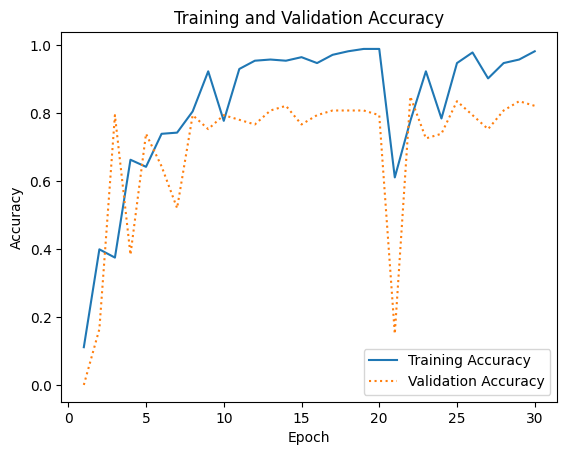

In [23]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

# <span style="font-family:cursive;text-align:center">🧪 Testing</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>For predicting on single tets files this code will be used. For each image file path obtained, the code performs the following operations:

- Loads the image using image.load_img() from the Keras preprocessing module, resizing it to the required dimensions of 224x224 pixels.
- Converts the image to a format compatible with the model for prediction (image.img_to_array() and np.expand_dims()).
- Utilizes the model for prediction on the image
- Retrieves class labels corresponding to the categories ('belly pain', 'burping', 'discomfort', 'hungry', 'tired').
- Prints the original file path and its predicted category, appending this information to the results list.</b>
</div>

In [24]:
import glob
import os

def get_png_files(directory):
    folders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired'] 
    png_files = []

    for folder_name in folders:
        folder_path = os.path.join(directory, folder_name)
        if os.path.exists(folder_path):
            png_files.extend(glob.glob(os.path.join(folder_path, '*.png')))
        else:
            print(f"Folder '{folder_name}' does not exist in '{directory}'.")

    return png_files

directory_path = '/kaggle/working/' 
png_files_list = get_png_files(directory_path)

results = []
for file_path in png_files_list:
    x = image.load_img(file_path, target_size=(224, 224))

    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)

    y = model.predict(x)

    class_labels = ['belly pain','burping','discomfort','hungry','tired']

    # for i, label in enumerate(class_labels):
    #     print(f'{label}: {y[0][i]}')

    results.append(f"Original:{file_path.split('/')[3]} Predicted: {class_labels[np.argmax(y)]}")
    
print('\n')

for i in results:
    print(i)
    print('\n')

1/1 [==============================] - 0s 30ms/step


Original:belly_pain Predicted: hungry


Original:burping Predicted: hungry


Original:discomfort Predicted: hungry


Original:hungry Predicted: hungry


Original:tired Predicted: hungry


